# Fig 2: SWOT in the California Current System
##### A.B Villas Bôas, G.Marechal, A Bohé

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

import cmocean
import sys
sys.path.insert(0, '../src')
from src import *

In [2]:
path_out = '../figures/'  # path, where to save the figure?
file_out = 'Fig02_CCS.png' # figure name?

### CALVAL data

In [3]:
date_SWOT = np.datetime64('2023-03-30T19:00')
lon_min, lon_max, lat_min, lat_max = -127.5, -120.3, 35, 40

#######################################################################################################################################
# ------------------------------------------------------ SWOT ------------------------------------------------------------------------
#######################################################################################################################################

ds_SWOT = xr.open_dataset('../data/SWOT/SWOT_CCS.nc')
ds_SWOT_HS = xr.open_dataset('../data/SWOT/SWOT_CCS_HS.nc')

#######################################################################################################################################
# ------------------------------------------------------ MODEL ------------------------------------------------------------------------
#######################################################################################################################################

ds_ww3 = xr.open_dataset('../data/WW3/WW3_CCS_HYCOM_outputs.nc')
ds_ww3_nocur = xr.open_dataset('../data/WW3/WW3_CCS_CTRL_outputs.nc')

#######################################################################################################################################
# ------------------------------------------------------ SWIM ------------------------------------------------------------------------
#######################################################################################################################################

ds_SWIM_ribbons = xr.open_dataset('../data/SWIM_offnadir/spec_CCS_SWIM_L2S.nc')
ds_SWIM_alti = xr.open_dataset('../data/SWIM_alti/alti_CCS_SWIM.nc')



In [4]:
mission = 'CCS'
###########
# --- Prepare axis and variables to plot
###########

wind_speed = (ds_ww3_nocur.uwnd**2 + ds_ww3_nocur.vwnd**2)**(1/2) # Wind Speed
current_speed = (ds_ww3.ucur**2 + ds_ww3.vcur**2)**(1/2) # Current Speed Model
u_speed_swot = (ds_SWOT.geo_zonal_current**2 + ds_SWOT.geo_meridional_current**2)**(1/2) # Current Speed SWOT

LON_HYCOM, LAT_HYCOM = np.meshgrid(ds_ww3.longitude.values, ds_ww3.latitude.values)

# ---  Arrows for current direction -> Model
n_quiver = 1
ugos_masked = np.ma.masked_where(current_speed<1, ds_ww3.ucur.values.squeeze()) # masking arrow
vgos_masked = np.ma.masked_where(current_speed<1, ds_ww3.vcur.values.squeeze()) # masking arrow


### Spectrum and BUlk from SWIM

In [5]:
theta_SWIM = ds_SWIM_ribbons.phi_geo[:].values * np.pi/180 
wavenumber_SWIM = ds_SWIM_ribbons.k.values
spec_SWIM = (ds_SWIM_ribbons.wave_spectra[:, :]*(ds_SWIM_ribbons.k.values)**(-1)).values.T

# Compute Bulk
print(f'The Bulk from SWIM are:')
print(f'________________________')
print('\n')
theta_swim, sub_k, e_kth, Lp, Dp, the_mp, sigp, Qp, Qkk = compute_bulk_l2s_SWIM(ds_SWIM_ribbons, 15) # Compute Bulk and wave spectrum from SWIM



The Bulk from SWIM are:
________________________


Qkk = 16.50218731368187 m
Peak Wavelength = 200.95063405268712 m
Peak Direction = 105.30963930262998 deg


### Figure


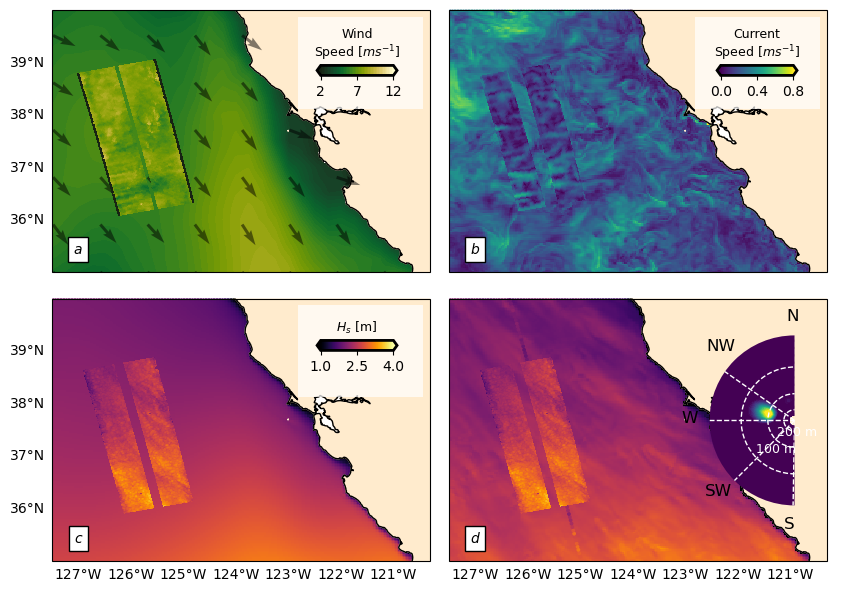

In [6]:
#######################################################################################################################################
# ------------------------------------------------------ Wind Speed -------------------------------------------------------------------
#######################################################################################################################################

# --- Vmin and Vmax
vmin = 2
vmax = 12
n_quiver = 30

fig = plt.figure(figsize = (10, 10))

##########
# --- Cartopy axes
##########
ax = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree()) 
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.0, linestyle='--', zorder=1)

# --- Create the feature
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

# --- Add features
ax.add_feature(cfeature.LAND,zorder=2,color='blanchedalmond')
ax.add_feature(cfeature.COASTLINE, zorder = 4)


# --- Activate and deactivate labels

gl.right_labels =False
gl.left_labels = True
gl.bottom_labels = False
gl.top_labels = False


# --- Plots

p1 = ax.contourf(ds_ww3.longitude, ds_ww3.latitude, wind_speed, np.linspace(vmin, vmax, 50), extend = 'both', cmap =  cmocean.cm.speed_r)
ax.pcolor(ds_SWOT.longitude, ds_SWOT.latitude, ds_SWOT.wind_speed, vmin = vmin, vmax = vmax, cmap = cmocean.cm.speed_r, zorder = 4)
ax.quiver(ds_ww3.longitude[::n_quiver], ds_ww3.latitude[::n_quiver], ds_ww3.uwnd[::n_quiver,::n_quiver]/wind_speed[::n_quiver,::n_quiver], ds_ww3.vwnd[::n_quiver,::n_quiver]/wind_speed[::n_quiver,::n_quiver],\
         scale = 15, width = 0.008, alpha = .5, zorder = 3)

ax.text(.08, .06, 'a', transform=ax.transAxes, ha='right', va='bottom', 
         style='italic', bbox={'facecolor':'white', 'alpha':1})


# --- Colorbar settings
cbbox = inset_axes(ax, '33%', '35%', loc = 1)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.set_facecolor([1,1,1,.7])
cbbox.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

cax = fig.add_axes([.39, .705, 0.08, 0.01])

cbar = plt.colorbar(p1, cax = cax, orientation = 'horizontal', extend = 'both', ticks = [vmin, (vmin+vmax)/2, vmax])
cbar.outline.set_linewidth(2)
cbar.ax.set_title('Wind\nSpeed [$ms^{-1}$]', fontsize = 9)


#######################################################################################################################################
# ------------------------------------------------------ Current Speed -------------------------------------------------------------------
#######################################################################################################################################

# --- Vmin and Vmax
vmin = 0
vmax = .8
n_quiver = 12 # number of quivers

##########
# --- Cartopy axes
##########
ax = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree()) 
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.0, linestyle='--', zorder=1)

# Create the feature
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

# --- Add features
ax.add_feature(cfeature.LAND,zorder=2,color='blanchedalmond')
ax.add_feature(cfeature.COASTLINE, zorder = 4)


# --- Activate and deactivate labels

gl.right_labels =False
gl.left_labels =False
gl.bottom_labels =False
gl.top_labels =False

# --- Plots
p1 = ax.pcolor(ds_ww3.longitude, ds_ww3.latitude, current_speed, vmin = vmin, vmax = vmax, cmap = 'viridis')
ax.quiver(LON_HYCOM[::n_quiver, ::n_quiver], LAT_HYCOM[::n_quiver, ::n_quiver], ugos_masked[::n_quiver, ::n_quiver]/current_speed[::n_quiver, ::n_quiver], vgos_masked[::n_quiver, ::n_quiver]/current_speed[::n_quiver, ::n_quiver], scale = 30, width = 0.005, facecolor = 'w', edgecolor = 'k', linewidth = .8)
ax.pcolor(ds_SWOT.longitude, ds_SWOT.latitude, u_speed_swot, vmin = vmin, vmax = vmax, cmap = 'viridis', zorder = 3)


ax.text(.08, .06, 'b', transform=ax.transAxes, ha='right', va='bottom', 
         style='italic', bbox={'facecolor':'white', 'alpha':1})


# --- Colorbar settings

cbbox = inset_axes(ax, '33%', '35%', loc = 1)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.set_facecolor([1,1,1,.7])
cbbox.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

cax = fig.add_axes([.79, .705, 0.08, 0.01])


cbar = plt.colorbar(p1, cax = cax, orientation = 'horizontal', extend = 'both', ticks = [vmin, (vmin+vmax)/2, vmax])
cbar.outline.set_linewidth(2)
cbar.ax.set_title('Current\nSpeed [$ms^{-1}$]', fontsize = 9)


#######################################################################################################################################
# --------------------------------------------- Significant Wave Height (CTRL) ------------------------------------------------------
#######################################################################################################################################

vmin = 1
vmax = 4

##########
# --- Cartopy axes
##########
ax = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())



gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.0, linestyle='--', zorder=1)


# --- Add features
ax.add_feature(cfeature.LAND,zorder=2,color='blanchedalmond')
ax.add_feature(cfeature.COASTLINE, zorder = 4)

# --- Activate and deactivate labels

gl.right_labels =False
gl.left_labels = True
gl.bottom_labels = True
gl.top_labels =False

# --- Plots
p1 = ax.pcolor(ds_ww3_nocur.longitude, ds_ww3_nocur.latitude, ds_ww3_nocur.hs, vmin = vmin, vmax = vmax, cmap = 'inferno')
ax.contourf(ds_SWOT_HS.reference_longitude, ds_SWOT_HS.reference_latitude, ds_SWOT_HS['swh_2Dmap_2.0km'], np.linspace(vmin, vmax, 100), cmap = 'inferno')


ax.text(.08, .06, 'c', transform=ax.transAxes, ha='right', va='bottom', 
         style='italic', bbox={'facecolor':'white', 'alpha':1})



# --- Colorbar settings

cbbox = inset_axes(ax, '33%', '35%', loc = 1)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.set_facecolor([1,1,1,.7])
cbbox.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)


# cax = fig.add_axes([.155, .75, 0.17, 0.02])
cax = fig.add_axes([.39, .43, 0.08, 0.01])

cbar = plt.colorbar(p1, cax = cax, orientation = 'horizontal', extend = 'both', ticks = [vmin, (vmin+vmax)/2, vmax])
cbar.outline.set_linewidth(2)
cbar.ax.set_title('$H_{s}$ [m]', fontsize = 9)

#######################################################################################################################################
# --------------------------------------------- Significant Wave Height (HYCOM) ------------------------------------------------------
#######################################################################################################################################

vmin = 1
vmax = 4






##########
# --- Cartopy axes
##########
ax = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())



gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.0, linestyle='--', zorder=1)

# --- Add features
ax.add_feature(cfeature.LAND,zorder=2,color='blanchedalmond')
ax.add_feature(cfeature.COASTLINE, zorder = 4)


# --- Activate and deactivate labels

gl.right_labels =False
gl.left_labels =False
gl.bottom_labels = True
gl.top_labels =False

# --- Plots

p1 = ax.pcolor(ds_ww3.longitude, ds_ww3.latitude, ds_ww3.hs, vmin = vmin, vmax = vmax, cmap = 'inferno')
plt.scatter(ds_SWIM_alti.longitude.values-360, ds_SWIM_alti.latitude.values, c = ds_SWIM_alti.swh.values, s = 3, vmin= vmin, vmax = vmax, cmap = plt.cm.inferno)

ax.contourf(ds_SWOT_HS.reference_longitude, ds_SWOT_HS.reference_latitude, ds_SWOT_HS['swh_2Dmap_2.0km'], np.linspace(vmin, vmax, 100), cmap = 'inferno')


# --- Arrows (along and across track)
# Define the start and end points of the original arrow
start = (-125.3, 39)
end = (-124, 38.3)

# Calculate the direction vector of the original arrow
dx = end[0] - start[0]
dy = end[1] - start[1]

# Get the perpendicular arrow
perpendicular_dx = -dy
perpendicular_dy = dx
length = np.sqrt(dx**2 + dy**2)  # same length as original arrow
perpendicular_end = (start[0] + perpendicular_dx / length, start[1] + perpendicular_dy / length)

# Plot arrows

# ax.annotate("", xy=end, xytext=start, arrowprops=dict(arrowstyle="->", lw=2, color="w", label="Original Arrow"))
# ax.annotate("", xy=perpendicular_end, xytext=start, arrowprops=dict(arrowstyle="->", lw=2, color="w", label="Perpendicular Arrow"))
# ax.text(-124.8, 39.2, 'X', color = 'w', fontsize = 9)
# ax.text(-124, 38, 'A', color = 'w', fontsize = 9)

# --- Colorbar settings

cax_cbar = fig.add_axes([.5, .5, 0.0001, 0.0001])
cax_cbar.set_xticks([])
cax_cbar.set_yticks([])
#ax.set_title('No Ref.')

ax.text(.08, .06, 'd', transform=ax.transAxes, ha='right', va='bottom', 
         style='italic', bbox={'facecolor':'white', 'alpha':1})

# --- SWIM Spectrum
vmin0 = 2
vmax0 = 10
side_spec = 'left'


# fig, ax = plt.subplots(subplot_kw = {'projection':'polar'})
plt.subplots_adjust(wspace=.05, hspace=-.4)

ax_inset = fig.add_axes([.74, .275, 0.17, .17], projection='polar')
# cax_cbar = fig.add_axes([.25, .1, .1, .01]) # position of the colorbar for spec. (decomment and comment it for the final version)
plot_polar_spec_SWIM(ax_inset, cax_cbar, theta_SWIM, wavenumber_SWIM, spec_SWIM, vmin0, vmax0, side_spec, path_out, file_out)
